# offspring counts
read in the offspring counts from MABE output file

In [1]:
dataFile = open("offCounts.csv", "r")
Lines = dataFile.readlines()
data = []
longest = 0

# strings -> lists
for l in Lines:
    if len(l) > 3:
        splitLine = l.split(',')[:-1]
        data.append([int(splitLine[i]) for i in range(len(splitLine))])
        longest = max(longest,len(data[-1]))
   
print('longest:',longest)

#make all lists the same length by padding with padValue
padValue = 0
for i in range(len(data)):
    if len(data[i]) < longest:
        #if sum(data[i]) != 2501:
        #    print("pop size:",i,sum(data[i]),data[i])
        data[i] += [padValue] * (longest - len(data[i]))



longest: 12


In [5]:
print(data[0:2])
print(sum(data[0]))

[[36712, 36887, 18447, 6050, 1526, 313, 56, 8, 1, 0, 0, 0], [36719, 36891, 18424, 6040, 1555, 315, 46, 10, 0, 0, 0, 0]]
100000


In [6]:
from collections import Counter
from scipy.stats import binom
import matplotlib.pyplot as plt


SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title



DR = {}
def getDriftReference(initialPop,finalPop):
    key = (initialPop,finalPop)
    if key not in DR:
        DR[key] = [binom.pmf(x, finalPop, 1/initialPop) for x in range(finalPop+1)]
    return DR[key]

def getSigThreshold(DR,p=0.05):
    probVal = 1.0
    index_i = 0
    while probVal > 0.05: #5% signifigance
        probVal -= DR[index_i]
        index_i += 1
    return index_i

def emd(P,Q):
    assert len(P) == len(Q)
    EMD = [0]
    for i in range(len(P)):
        EMD.append(P[i]-Q[i]+EMD[-1])
    return sum([abs(d) for d in EMD])

def getSS(offCounts_1d,initialPop,finalPop):
    Counts = Counter(offCounts_1d)
    Observed = [Counts[x]/initialPop if x in Counts else 0 for x in range(finalPop+1)]
    return emd(getDriftReference(initialPop,finalPop),Observed)

# convert MABE output into format expected by Selection impact
this process is expensive. It's a hack to avoid re-writing the selection impact code, so that the same code can be used for everything. 

In [7]:
from statistics import mean
#EMD ss measure
SS = []
popsize = sum(data[0])
for gen in data:
    countVec = []
    for i, count in enumerate(gen):
        countVec.extend([i for _ in range(count)])
    SS.append(getSS(countVec,popsize,popsize))
    

# load in fitness-over-time data from MABE output
load in the population average and population max fitness from the same MABE run used to generate the offspring counts.

## plot side-by-side the selection impact metric and the fitness-over-time

update,repeat,time,meanGenome,maxGenome,meanScore,maxScore



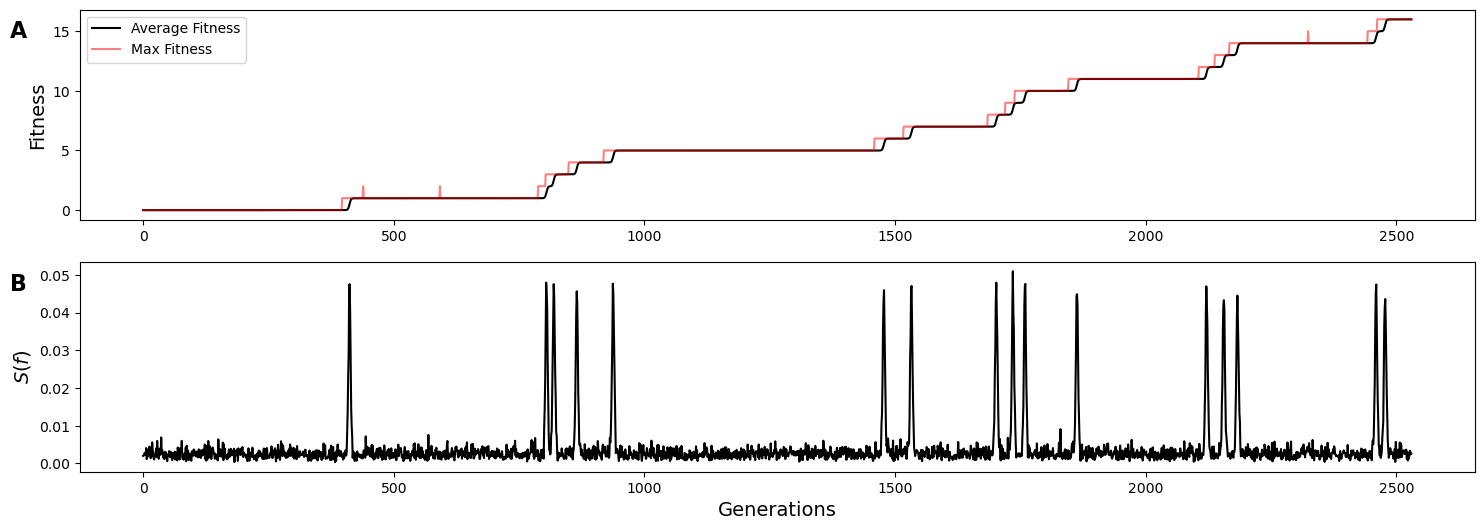

In [8]:
dataFile = open("pop.csv", "r")
Lines = dataFile.readlines()
print(Lines[0])
data2 =  [list(map(float,line.strip().split(",")[-2:])) for line in Lines[1:]]
aveData, maxData = list(zip(*data2[1:]))

start = 0
stop = len(SS)
textX = -0.05
textY = 0.95
fig, axs = plt.subplots(2,1,figsize=(18,6))
axs[0].plot(list(range(start,stop)),aveData[start:stop],label="Average Fitness",color="k")
axs[0].plot(list(range(start,stop)),maxData[start:stop],label="Max Fitness",color="r",alpha=0.5)
axs[0].set_ylabel("Fitness")
axs[0].legend()
axs[0].text(textX, textY, "A", transform=axs[0].transAxes,fontsize=16, fontweight='bold', va='top')
axs[1].plot(list(range(start,stop)),SS[start:stop],color="k",label="Selection Strength")
# axs[1].plot(list(range(start,stop)),AVEDATA,linewidth=2,color="r",label="Traveling Average")
axs[1].set_xlabel("Generations")
axs[1].set_ylabel("$S(f)$")
axs[1].text(textX, textY, "B", transform=axs[1].transAxes,fontsize=16, fontweight='bold', va='top')
# axs[1].legend()
# axs[1].set_yscale("log")
plt.savefig('fitnessOverTimeSS.pdf', bbox_inches='tight')
plt.show()